<a href="https://colab.research.google.com/github/armiro/canine-disease-diagnosis/blob/main/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

In [2]:
path = "/content/normalized_dataset.csv"
dataset = pd.read_csv(path)

features = dataset.iloc[:, :30].values
labels = dataset.iloc[:, 30:]

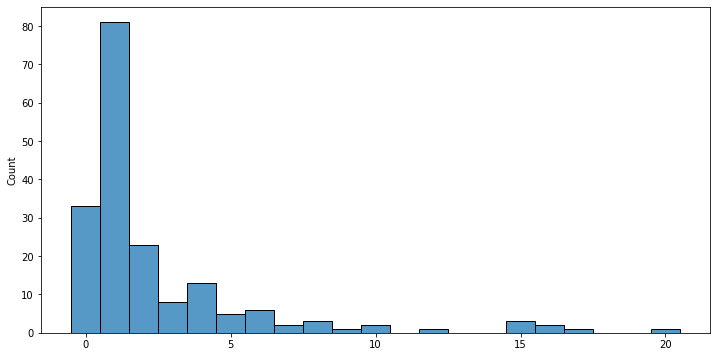

In [3]:
# one last prep step for labels: we have too many (214) labels which could be shrunken
# to much smaller number of labels. we have to let go of labels with few occurances
label_freqs_list = list()
label_names = list()
for label, column in labels.iteritems():
    label_names.append(label)
    label_freqs_list.append(np.sum(column))

fig = plt.figure(figsize=(12, 6))
sns.histplot(data=label_freqs_list, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()
# which threshold? we can omit labels with freq < 5 (we can change later to see differences)

In [4]:
drop_list = list()
for label, column in labels.iteritems():
    if np.sum(column) < 5:
        drop_list.append(label)

labels = labels.drop(columns=drop_list).values
print('number of labels is reduced from %d to %d' % (len(label_names), len(labels[0])))

number of labels is reduced from 214 to 56


In [5]:
onehot_encoder_1 = OneHotEncoder(categories='auto', drop='first', sparse=False)
encoded_mat_1 = onehot_encoder_1.fit_transform(X=features[:, 0].reshape(-1, 1))

onehot_encoder_2 = OneHotEncoder(categories='auto', drop='first', sparse=False)
encoded_mat_2 = onehot_encoder_2.fit_transform(X=features[:, 2].reshape(-1, 1))

features = np.concatenate((encoded_mat_1, features[:, 1].reshape(-1, 1), 
                               encoded_mat_2, features[:, 3:]), axis=1)

In [6]:
features[:, 7] = features[:, 7] / np.max(features[:, 7])

# split the dataset into training-set and test-set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=17)

In [9]:
# np.max(X_train)

11.2721519

In [11]:
from sklearn.neural_network import MLPClassifier

# class weights?
classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                           max_iter=500, verbose=1)

In [ ]:
classifier.fit(X=X_train, y=y_train)

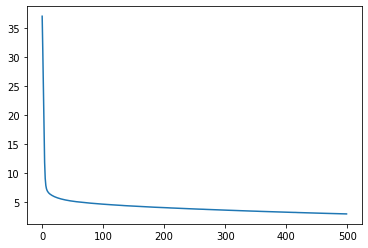

In [13]:
plt.plot(classifier.loss_curve_)
plt.show()

In [31]:
idx = np.random.randint(0, len(X_train))
print(idx)
print(classifier.predict(X=np.expand_dims(X_train[idx], axis=0)))
print(y_train[idx])

436
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
